In [1]:
#imports

import tensorflow as tf
import numpy as np
import pandas as pd
import os
import glob
import cv2
import re
import keras
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Conv2D,Dense,Dropout,Flatten,MaxPooling2D
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.utils import np_utils
from PIL import ImageFile 
import matplotlib.pyplot as plt
from keras.preprocessing import image                  
from tqdm import tqdm
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, roc_curve, auc
from matplotlib.colors import ListedColormap
import warnings; warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report
import seaborn as sns
from keras.applications.vgg16 import VGG16

# **Importing data**

In [2]:
data_dir = "/Users/manideep/Documents/Courses/Intro to dataScience/Project/leafsnap-dataset/dataset/images/field"

root, dirs, files = next(os.walk(data_dir), ([],[],[]))

dirs.sort() #sorting all the directories

184


# **Resising the image**

In [3]:
def resize(fl, img_height, img_width):
    img = cv2.imread(fl)
    resized = cv2.resize(img, (img_height, img_width))
    return resized

# Making  data

In [4]:
def get_data():
    X = []
    y = []
    classes = []
    dir_names = []
    classes_count = dict()
    
    for dir_name in dirs[:30]:
        class_name = dir_name.replace('_','')
        classes.append(class_name)
        
        dir_names.append(dir_name)
        
        path = os.path.join(data_dir,dir_name,'*.jpg')
        images = glob.glob(path)
        
        classes_count[class_name] = len(images)
        
        
        for fl in images:
            flbase = os.path.basename(fl)
            img = resize(fl, 64, 64)
            X.append(img)
            y.append(class_name)
    return X, y, classes,dir_names,classes_count

In [5]:
X, y, classes,dir_names,classes_count = get_data()

In [6]:
df = pd.DataFrame.from_dict(classes_count, orient='index')

print(df)

                           0
abiesconcolor             51
abiesnordmanniana         35
acercampestre             36
acerginnala               31
acergriseum               46
acernegundo               33
acerpalmatum              92
acerpensylvanicum         35
acerplatanoides           20
acerpseudoplatanus        15
acerrubrum                45
acersaccharinum           39
acersaccharum             24
aesculusflava             15
aesculusglabra            44
aesculushippocastamon     19
aesculuspavi             101
ailanthusaltissima        16
albiziajulibrissin        28
amelanchierarborea        43
amelanchiercanadensis     35
amelanchierlaevis         31
asiminatriloba            49
betulaalleghaniensis      33
betulajacqemontii         22
betulalenta               11
betulanigra               20
betulapopulifolia         26
broussonettiapapyrifera   54
carpinusbetulus           15


In [7]:
X = np.array(X)


print('Shape of X is',len(X))
print('Shape of Y is',len(y))

Shape of X is 1064
Shape of Y is 1064


In [8]:
class_dict={}
for i,class_name in enumerate(classes):
    class_dict[i] = class_name
    

print(len(class_dict))

30


# Sample images

Text(0.5, 1.0, 'acerpseudoplatanus')

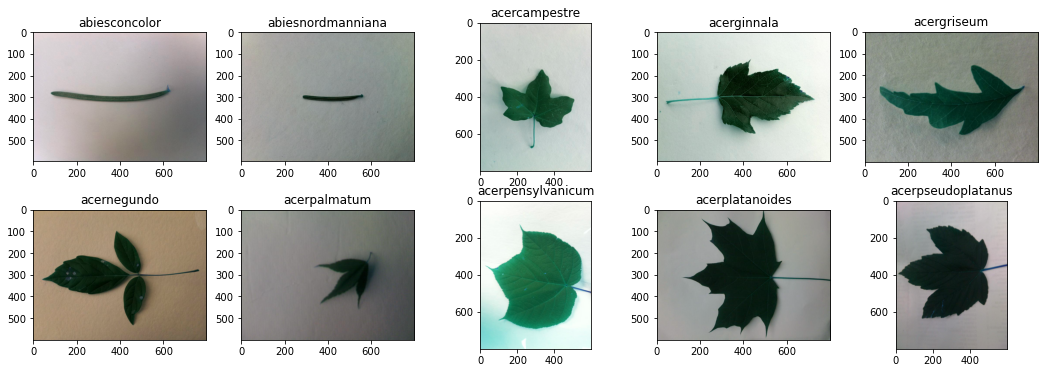

In [9]:
# Sample Image for each class
img_array=[]
for i in dir_names:
    path = os.path.join(data_dir, i)
    
    for img in os.listdir(path):
        imgs = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
        img_array.append(imgs)
        break

f, axarr = plt.subplots(2,5,figsize=(18,6))  

axarr[0,0].imshow(img_array[0])
axarr[0,0].set_title(class_dict[0])

axarr[0,1].imshow(img_array[1])
axarr[0,1].set_title(class_dict[1]) 

axarr[0,2].imshow(img_array[2])
axarr[0,2].set_title(class_dict[2]) 

axarr[0,3].imshow(img_array[3])
axarr[0,3].set_title(class_dict[3]) 

axarr[0,4].imshow(img_array[4])
axarr[0,4].set_title(class_dict[4]) 

axarr[1,0].imshow(img_array[5])
axarr[1,0].set_title(class_dict[5]) 

axarr[1,1].imshow(img_array[6])
axarr[1,1].set_title(class_dict[6]) 

axarr[1,2].imshow(img_array[7])
axarr[1,2].set_title(class_dict[7]) 

axarr[1,3].imshow(img_array[8])
axarr[1,3].set_title(class_dict[8]) 

axarr[1,4].imshow(img_array[9])
axarr[1,4].set_title(class_dict[9])

# Splitting into training and test data

In [11]:
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size = 0.3,stratify=y,random_state=42)

In [14]:
Xtrain[5].shape

(64, 64, 3)

# Downloading ResNet50

In [15]:
VGG_model = VGG16(weights='imagenet', include_top=False,)

2021-12-06 23:08:15.572196: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-06 23:08:15.572868: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1


In [16]:
for layer in VGG_model.layers:
    layer.trainable = False

# Extracting training features

In [17]:
%%time

feature_extractor_train=VGG_model.predict(Xtrain)

2021-12-06 23:08:17.842004: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-06 23:08:17.846198: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-12-06 23:08:17.911646: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


CPU times: user 203 ms, sys: 260 ms, total: 463 ms
Wall time: 1.84 s


# Extracting testing features

In [18]:
%%time

feature_extractor_test=VGG_model.predict(Xtest)

2021-12-06 23:08:19.666696: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


CPU times: user 99.3 ms, sys: 88.4 ms, total: 188 ms
Wall time: 770 ms


In [19]:
training_features = feature_extractor_train.reshape(feature_extractor_train.shape[0], -1)
testing_features = feature_extractor_test.reshape(feature_extractor_test.shape[0], -1)

In [20]:
xtrain = training_features
xtest = testing_features

print(xtrain.shape,xtest.shape)

(744, 2048) (320, 2048)


# Scaling

In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.fit_transform(xtest)

# Classification algorthim

In [27]:
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier()


param_grid = {'criterion': ['gini', 'entropy'],
              'splitter': ['best', 'random'],
              'max_depth': np.arange(1, 20, 2),
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4, 10],
              'max_features': ['auto', 'sqrt', 'log2', None]}


skf = StratifiedKFold(n_splits=3, shuffle = True, random_state = 1001)

gv = GridSearchCV(dtree,param_grid,verbose=1, cv = skf.split(xtrain,ytrain),scoring= 'accuracy')

In [28]:
%%time

# fit the classifier to the training data
gv.fit(xtrain, ytrain)

Fitting 3 folds for each of 1920 candidates, totalling 5760 fits
CPU times: user 1min 16s, sys: 1.01 s, total: 1min 17s
Wall time: 1min 18s


GridSearchCV(cv=<generator object _BaseKFold.split at 0x2867fb120>,
             estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                         'max_features': ['auto', 'sqrt', 'log2', None],
                         'min_samples_leaf': [1, 2, 4, 10],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']},
             scoring='accuracy', verbose=1)

In [29]:
ypred = gv.predict(xtest)
# Get Probability estimates
yprob = gv.predict_proba(xtest)

# Viewing best parameters

In [30]:
#print('\n All results:')
#print(gv.cv_results_)
print('\n Best estimator:')
print(gv.best_estimator_)
print('\n Best hyperparameters:')
print(gv.best_params_)


 Best estimator:
DecisionTreeClassifier(criterion='entropy', max_depth=9)

 Best hyperparameters:
{'criterion': 'entropy', 'max_depth': 9, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}


Accuracy score: 58.13%
Precision score: 48.78%
Recall score: 49.30%
                         precision    recall  f1-score   support

          abiesconcolor       0.83      1.00      0.91        15
      abiesnordmanniana       0.92      1.00      0.96        11
          acercampestre       0.75      0.55      0.63        11
            acerginnala       0.20      0.11      0.14         9
            acergriseum       0.62      0.57      0.59        14
            acernegundo       0.18      0.20      0.19        10
           acerpalmatum       0.73      0.79      0.76        28
      acerpensylvanicum       0.55      0.55      0.55        11
        acerplatanoides       0.33      0.17      0.22         6
     acerpseudoplatanus       0.40      0.50      0.44         4
             acerrubrum       0.43      0.43      0.43        14
        acersaccharinum       0.73      0.67      0.70        12
          acersaccharum       0.50      0.43      0.46         7
          aesculusfla

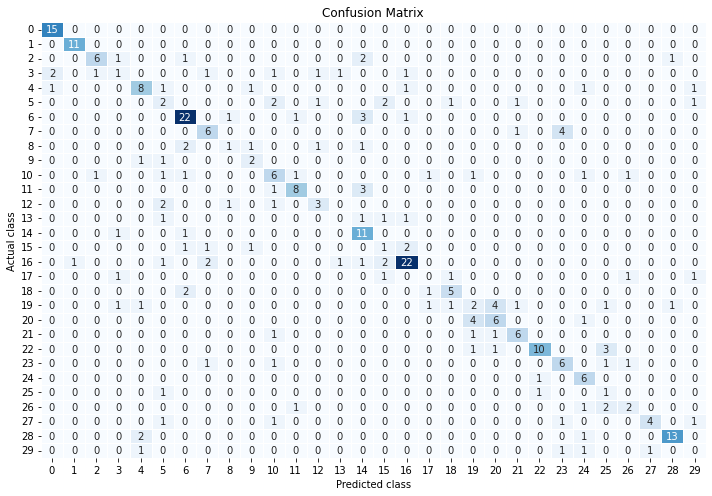

In [31]:
fig, ax1 = plt.subplots(1, 1, figsize=(10, 7))
# Plot confusion matrix
cm = confusion_matrix(ytest, ypred)
sns.heatmap(cm, annot = True, cbar = False, fmt = "d", linewidths = .5, cmap = "Blues", ax = ax1)
ax1.set_title("Confusion Matrix")
ax1.set_xlabel("Predicted class")
ax1.set_ylabel("Actual class")
fig.tight_layout()

print('Accuracy score: %.2f%%' %(accuracy_score(ytest, ypred)*100))  
print('Precision score: %.2f%%' % (precision_score(ytest, ypred,average='macro')*100))
print('Recall score: %.2f%%' % (recall_score(ytest, ypred,average='macro')*100))

print(classification_report(ytest, ypred))


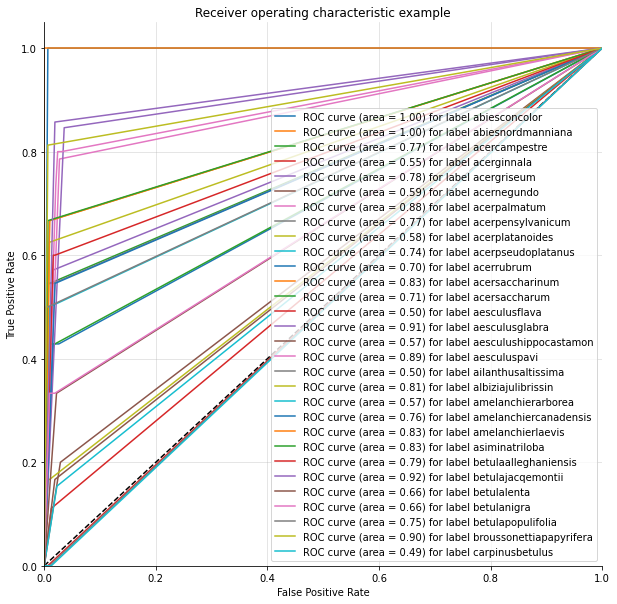

<Figure size 432x288 with 0 Axes>

In [32]:
def plot_multiclass_roc( X_test, y_test, n_classes, figsize=(17, 6)):

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(ytest, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], yprob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %s' % (roc_auc[i], classes[i]))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()
    plt.savefig('resnet_dt_roc.png')
    
plot_multiclass_roc(xtest, ytest, n_classes=30, figsize=(10, 10))